In [2]:
# !pip install cmake
# !pip install dlib
# !pip install face_recognition
# from google.colab import drive
# drive.flush_and_unmount()
# drive.mount('/content/drive/', force_remount=True)

# import os
# os.chdir(os.path.join('drive', 'MyDrive', 'Colab Notebooks', 'DeepFake Detector'))
# print(f'current cwd = {os.getcwd()}')

In [3]:
import os
import cv2
import PIL
import face_recognition
import numpy as np
from PIL import Image
from operator import itemgetter
from heapq import nsmallest
from math import ceil
from IPython.display import display
%matplotlib inline

In [4]:
video_dir_path = os.path.join('.', 'Celeb-DF-v2', 'Celeb-real')
# video_dir_path = os.path.join('.', 'Celeb-DF-v2', 'Celeb-synthesis')
video_listdir = os.listdir(video_dir_path)
# video = os.path.join(video_dir_path, 'id1_0007.mp4') #best case
video = os.path.join(video_dir_path, video_listdir[17]) #avg case real
# video = os.path.join(video_dir_path, 'id10_id12_0007.mp4') #avg case fake
# 
# video = os.path.join(video_dir_path, 'id34_0007.mp4') #hard
# video = os.path.join(video_dir_path, 'id44_0005.mp4') #movement

# video_listdir[17]


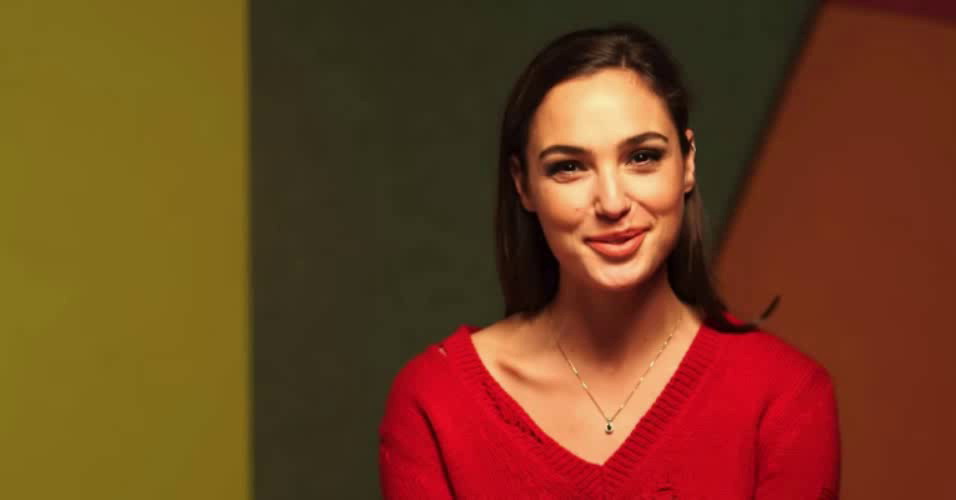

In [5]:
video_path = video
interval = 1


# get_every_frame
frames = []
vidcap = cv2.VideoCapture(video_path)
success, image = vidcap.read()

count = 0
while success:
    if not count % interval:
        frames.append(image[:, :, ::-1])
    success, image = vidcap.read()
    count += 1

Image.fromarray(frames[0])

In [6]:
# zoomed = True
# get_face_locations ZOOMED

face_coordinates = []
for frame in frames:
    coordinates_found = face_recognition.face_locations(frame)
    if coordinates_found is not None and len(coordinates_found):
        face_coordinates.append(coordinates_found[-1])
    else:
        face_coordinates.append(None)
        
# cleaned_face_coordinates = [f for f in face_coordinates if f is not None]
# cleaned_face_coordinates[-10:]

In [7]:
cleaned_face_coordinates = np.asarray([f for f in face_coordinates if f is not None])

# find centroid of face locations
length = cleaned_face_coordinates.shape[0]
sum_t = np.sum(cleaned_face_coordinates[:, 0])
sum_r = np.sum(cleaned_face_coordinates[:, 1])
sum_b = np.sum(cleaned_face_coordinates[:, 2])
sum_l = np.sum(cleaned_face_coordinates[:, 3])

centroid = np.asarray((sum_t, sum_r, sum_b, sum_l)) / length
centroid

array([133.95766129, 757.40927419, 327.61693548, 563.96572581])

In [8]:
# dist from centroid to face loc for every face found

dist_from_centroid = []
for coord in face_coordinates:
    if coord is not None:
        dist_from_centroid.append(np.linalg.norm(centroid-coord))
    else:
        dist_from_centroid.append(coord)
        
dist_from_centroid[-10:]

[87.97377881768405,
 87.97377881768405,
 87.97377881768405,
 87.97377881768405,
 None,
 None,
 None,
 None,
 None,
 None]

In [17]:
# thrshld = min(filter(bool, dist_from_centroid))*4
thrshld = nsmallest(4, set(filter(bool, dist_from_centroid)))[-1]
thrshld

36.04498020768602

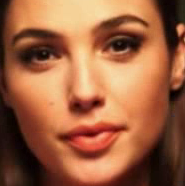

In [18]:
stable_faces = []
for dist, coord, frame in zip(dist_from_centroid, face_coordinates, frames):
    if dist is not None:
        if dist <= thrshld:
            t,r,b,l = coord
            stable_faces.append(frame[t:b, l:r])
Image.fromarray(stable_faces[0])

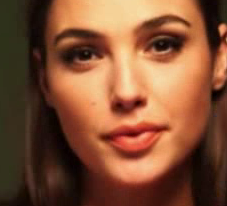

In [19]:
face_coordinates_in_thrshld = []
for dist, coord in zip(dist_from_centroid, face_coordinates):
    if dist is not None and dist <= thrshld:
        face_coordinates_in_thrshld.append(coord)

face_coordinates_in_thrshld = [f for f in face_coordinates_in_thrshld if f is not None]
min_top = min(face_coordinates_in_thrshld, key=itemgetter(0))[0]
max_right = max(face_coordinates_in_thrshld, key=itemgetter(1))[1]
max_bottom = max(face_coordinates_in_thrshld, key=itemgetter(2))[2]
min_left = min(face_coordinates_in_thrshld, key=itemgetter(3))[3]

max_stable_faces = []
for dist, frame in zip(dist_from_centroid, frames):
    if dist is not None and dist <= thrshld:
        max_stable_faces.append(frame[min_top:max_bottom, min_left:max_right])
Image.fromarray(max_stable_faces[0])

In [20]:
def average(frames):
    h,w,c = frames[0].shape
    N = len(frames)

    avg = np.zeros((h,w,c), np.float)

    for frame in frames:
        frame = np.array(frame, dtype=np.float)
        avg += (frame/N)

    avg = np.array(np.round(avg), dtype=np.uint8)

    return avg

In [21]:
def difference(frames, interval):
    h,w,c = frames[0].shape
    
    diff = np.zeros((h,w,c), np.float)

    for current_frame, next_frame in zip(frames[::interval], frames[interval::interval]):
        current_frame = np.array(current_frame, dtype=np.float)
        next_frame = np.array(next_frame, dtype=np.float)
        diff += np.absolute(next_frame - current_frame)

    diff = np.array(np.round(diff), dtype=np.uint8)

    return diff

In [22]:
len(max_stable_faces), len(frames), len(max_stable_faces)/len(frames)*100

(261, 502, 51.992031872509955)


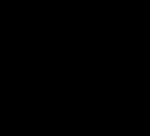
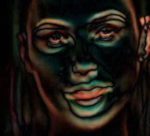
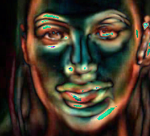
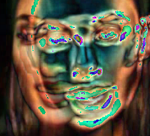
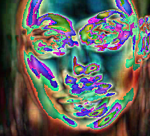
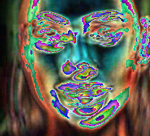
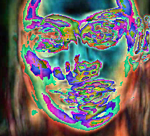
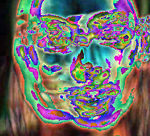
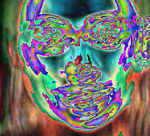
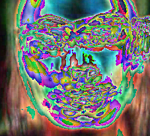
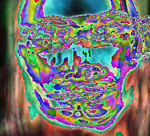
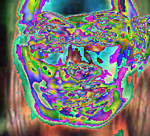
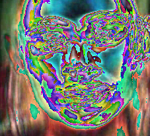
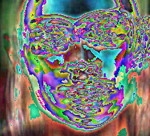
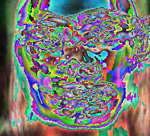
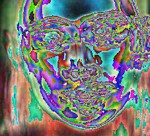
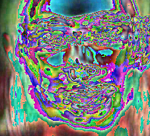
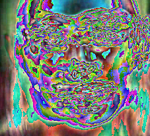
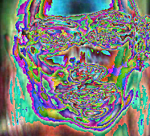
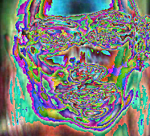
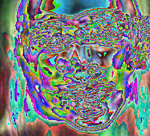
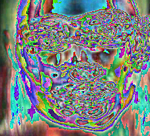
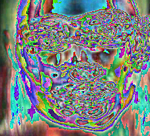
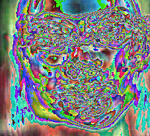
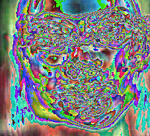
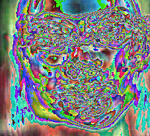
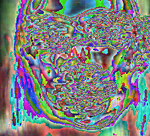
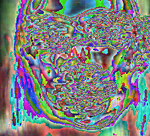
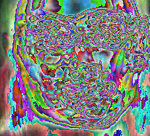
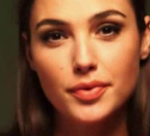


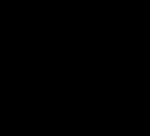
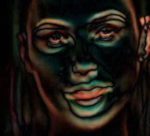
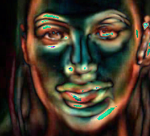
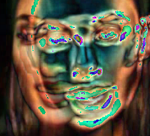
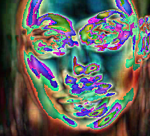
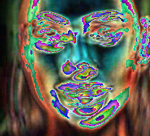
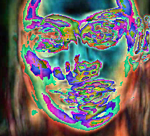
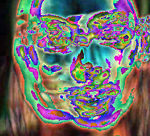
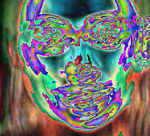
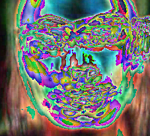
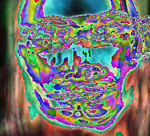
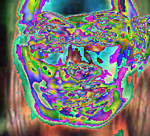
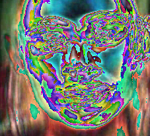
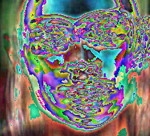
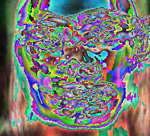
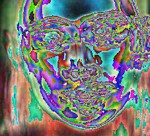
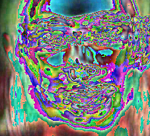
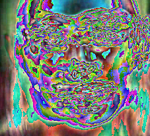
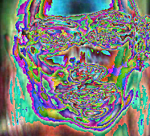
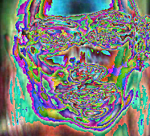
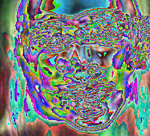
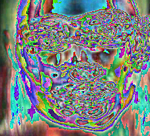
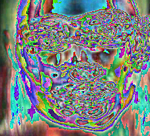
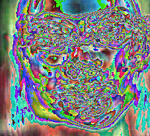
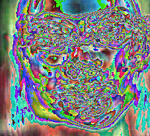
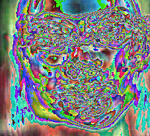
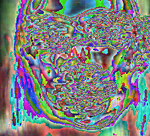
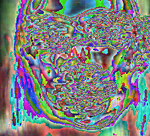
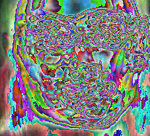
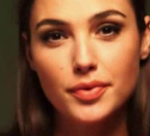

In [28]:
import ipyplot
diff_array = [difference(
    max_stable_faces,
    interval=ceil(len(max_stable_faces)/i))
              for i in range(1,30,1)]

images_array = list(map(Image.fromarray,
               diff_array+[max_stable_faces[0],average(max_stable_faces)]))

ipyplot.plot_images(images_array)


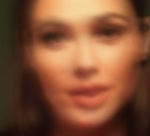
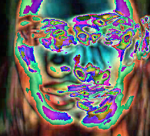


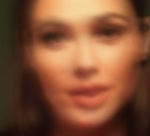
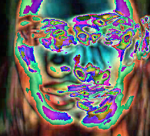

In [24]:
avger = Image.fromarray(average(max_stable_faces))
differ = Image.fromarray(difference(max_stable_faces, interval=50))
ipyplot.plot_images([avger, differ], labels=["s", "s"])